In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as kt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
print (X_train_valid[0:3])
print (y_train_valid[0:3])
print (X_train_valid[0:3].shape)

[[[  5.6640625    2.19726562  -1.3671875  ...  -9.91210938  -8.3984375
    -8.25195312]
  [  9.47265625   4.98046875   2.1484375  ...  -7.2265625   -7.421875
    -3.95507812]
  [  7.51953125   3.85742188   1.31835938 ...  -9.03320312  -7.91015625
    -7.6171875 ]
  ...
  [ 17.08984375  14.6484375   10.7421875  ...   1.46484375  -0.48828125
     1.46484375]
  [ 15.13671875   7.8125       1.953125   ...   0.48828125  -1.46484375
    -0.9765625 ]
  [  8.30078125   1.46484375   0.9765625  ...   6.8359375    7.32421875
     6.34765625]]

 [[  9.08203125  15.91796875  17.82226562 ...  -4.05273438  -2.97851562
    -1.171875  ]
  [ 10.15625     13.33007812  14.01367188 ...  -3.46679688  -5.078125
    -4.44335938]
  [  8.44726562  14.84375     16.45507812 ...  -4.93164062  -4.1015625
    -3.17382812]
  ...
  [ 11.71875      6.8359375    6.34765625 ...  -5.37109375  -0.48828125
     1.46484375]
  [ 11.23046875   9.765625     6.8359375  ...   0.          -1.953125
    -4.39453125]
  [ 10.7421875 

In [5]:
# get the indices of each class type occurring in the training set
idx_c1 = np.where(y_train_valid == 769)[0]
idx_c2 = np.where(y_train_valid == 770)[0]
idx_c3 = np.where(y_train_valid == 771)[0]
idx_c4 = np.where(y_train_valid == 772)[0]
print (np.unique(y_train_valid))
print(y_train_valid.shape)
print(idx_c1.shape)
print(idx_c2.shape)
print(idx_c3.shape)
print(idx_c4.shape)

[769 770 771 772]
(2115,)
(529,)
(513,)
(543,)
(530,)


In [6]:
# get the indices of each person occurence in the training set
idx_p0 = np.where(person_train_valid == 0)[0]
idx_p1 = np.where(person_train_valid == 1)[0]
idx_p2 = np.where(person_train_valid == 2)[0]
idx_p3 = np.where(person_train_valid == 3)[0]
idx_p4 = np.where(person_train_valid == 4)[0]
idx_p5 = np.where(person_train_valid == 5)[0]
idx_p6 = np.where(person_train_valid == 6)[0]
idx_p7 = np.where(person_train_valid == 7)[0]
idx_p8 = np.where(person_train_valid == 8)[0]
print (np.unique(person_train_valid))
print (np.unique(person_test))
print(idx_p4.shape)
print(idx_p6.shape)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
(235,)
(238,)


In [7]:
# separate data by person
p0_data_X = X_train_valid[idx_p0] 
p0_data_y = y_train_valid[idx_p0]
p1_data_X = X_train_valid[idx_p1] 
p1_data_y = y_train_valid[idx_p1]
p2_data_X = X_train_valid[idx_p2] 
p2_data_y = y_train_valid[idx_p2]
p3_data_X = X_train_valid[idx_p3] 
p3_data_y = y_train_valid[idx_p3]
p4_data_X = X_train_valid[idx_p4] 
p4_data_y = y_train_valid[idx_p4]
p5_data_X = X_train_valid[idx_p5] 
p5_data_y = y_train_valid[idx_p5]
p6_data_X = X_train_valid[idx_p6] 
p6_data_y = y_train_valid[idx_p6]
p7_data_X = X_train_valid[idx_p7] 
p7_data_y = y_train_valid[idx_p7]
p8_data_X = X_train_valid[idx_p8] 
p8_data_y = y_train_valid[idx_p8]


In [8]:
# separate person0's data by class
p0_class1_data = p0_data_X[np.where(p0_data_y == 769)[0]] 
p0_class2_data = p0_data_X[np.where(p0_data_y == 770)[0]]
p0_class3_data = p0_data_X[np.where(p0_data_y == 771)[0]]
p0_class4_data = p0_data_X[np.where(p0_data_y == 772)[0]]

# get a random sample of each class type
idx1 = np.random.choice(p0_class1_data.shape[0])
idx2 = np.random.choice(p0_class2_data.shape[0])
idx3 = np.random.choice(p0_class3_data.shape[0])
idx4 = np.random.choice(p0_class4_data.shape[0])
p0_class1_sample = p0_class1_data[idx1]
p0_class2_sample = p0_class2_data[idx2]
p0_class3_sample = p0_class3_data[idx3]
p0_class4_sample = p0_class4_data[idx4]
print(p0_class1_sample.shape)

(25, 1000)


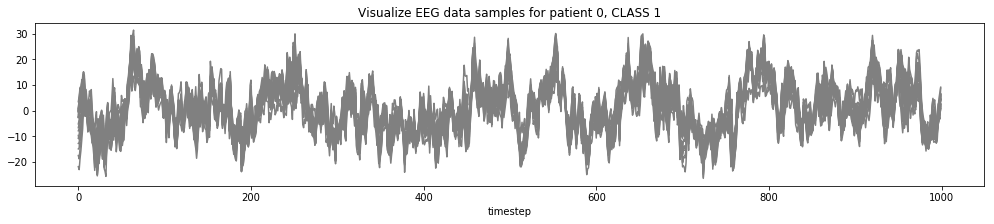

In [10]:
# Plot EEG for class 1 = move left arm
for i in np.arange(22): 
    plt.title("Visualize EEG data samples for patient 0, CLASS 1")
    plt.xlabel("timestep")
    plt.plot(p0_class1_sample[i], color='gray')

plt.gcf().set_size_inches(17, 3)
plt.show()

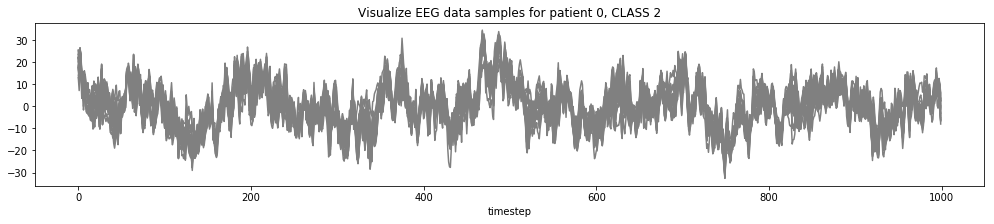

In [12]:
# Plot EEG for class 2 = move right arm
for i in np.arange(22): 
    plt.title("Visualize EEG data samples for patient 0, CLASS 2")
    plt.xlabel("timestep")
    plt.plot(p0_class2_sample[i], color='gray')

plt.gcf().set_size_inches(17, 3)
plt.show()

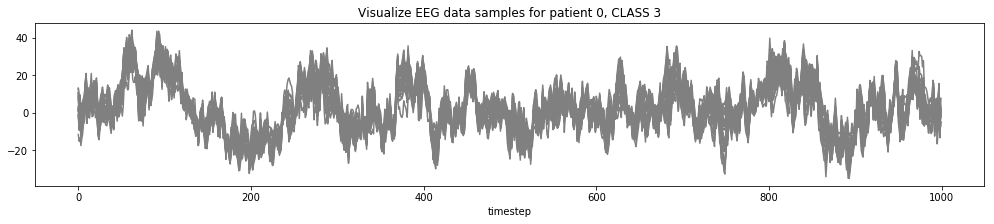

In [13]:
# Plot EEG for class 3 = move feet
for i in np.arange(22): 
    plt.title("Visualize EEG data samples for patient 0, CLASS 3")
    plt.xlabel("timestep")
    plt.plot(p0_class3_sample[i], color='gray')

plt.gcf().set_size_inches(17, 3)
plt.show()

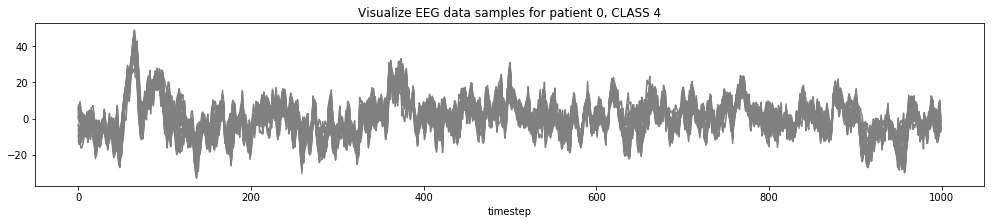

In [14]:
# Plot EEG for class 4 = move tongue
for i in np.arange(22): 
    plt.title("Visualize EEG data samples for patient 0, CLASS 4")
    plt.xlabel("timestep")
    plt.plot(p0_class4_sample[i],  color='gray')

plt.gcf().set_size_inches(17, 3)
plt.show()